# Preveja os usuários com alta chance de deixar seu  Streaming

Utilize um modelo de classificação para mapear qual o perfil de usuários tem mais chance de deixar sua plataforma de streaming. Compreender quem é o perfil que está aumentando o churn do seu negócio é essencial para tomar ações que reduzam essas perdas, seja alterando critérios na venda ou modificando o produto.

## Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing, model_selection, linear_model, metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Base de dados

In [ ]:
# Carga da base de dados
base_dados = pd.read_csv('streaming_data.csv', sep=',')
base_dados.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


## Análise Exploratória dos dados

In [ ]:
# Realização da descrição estatística dos dados
base_dados.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [ ]:
# Verificação dos tipos de dados
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
# Contagem de valores nulos por coluna
base_dados.isnull().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

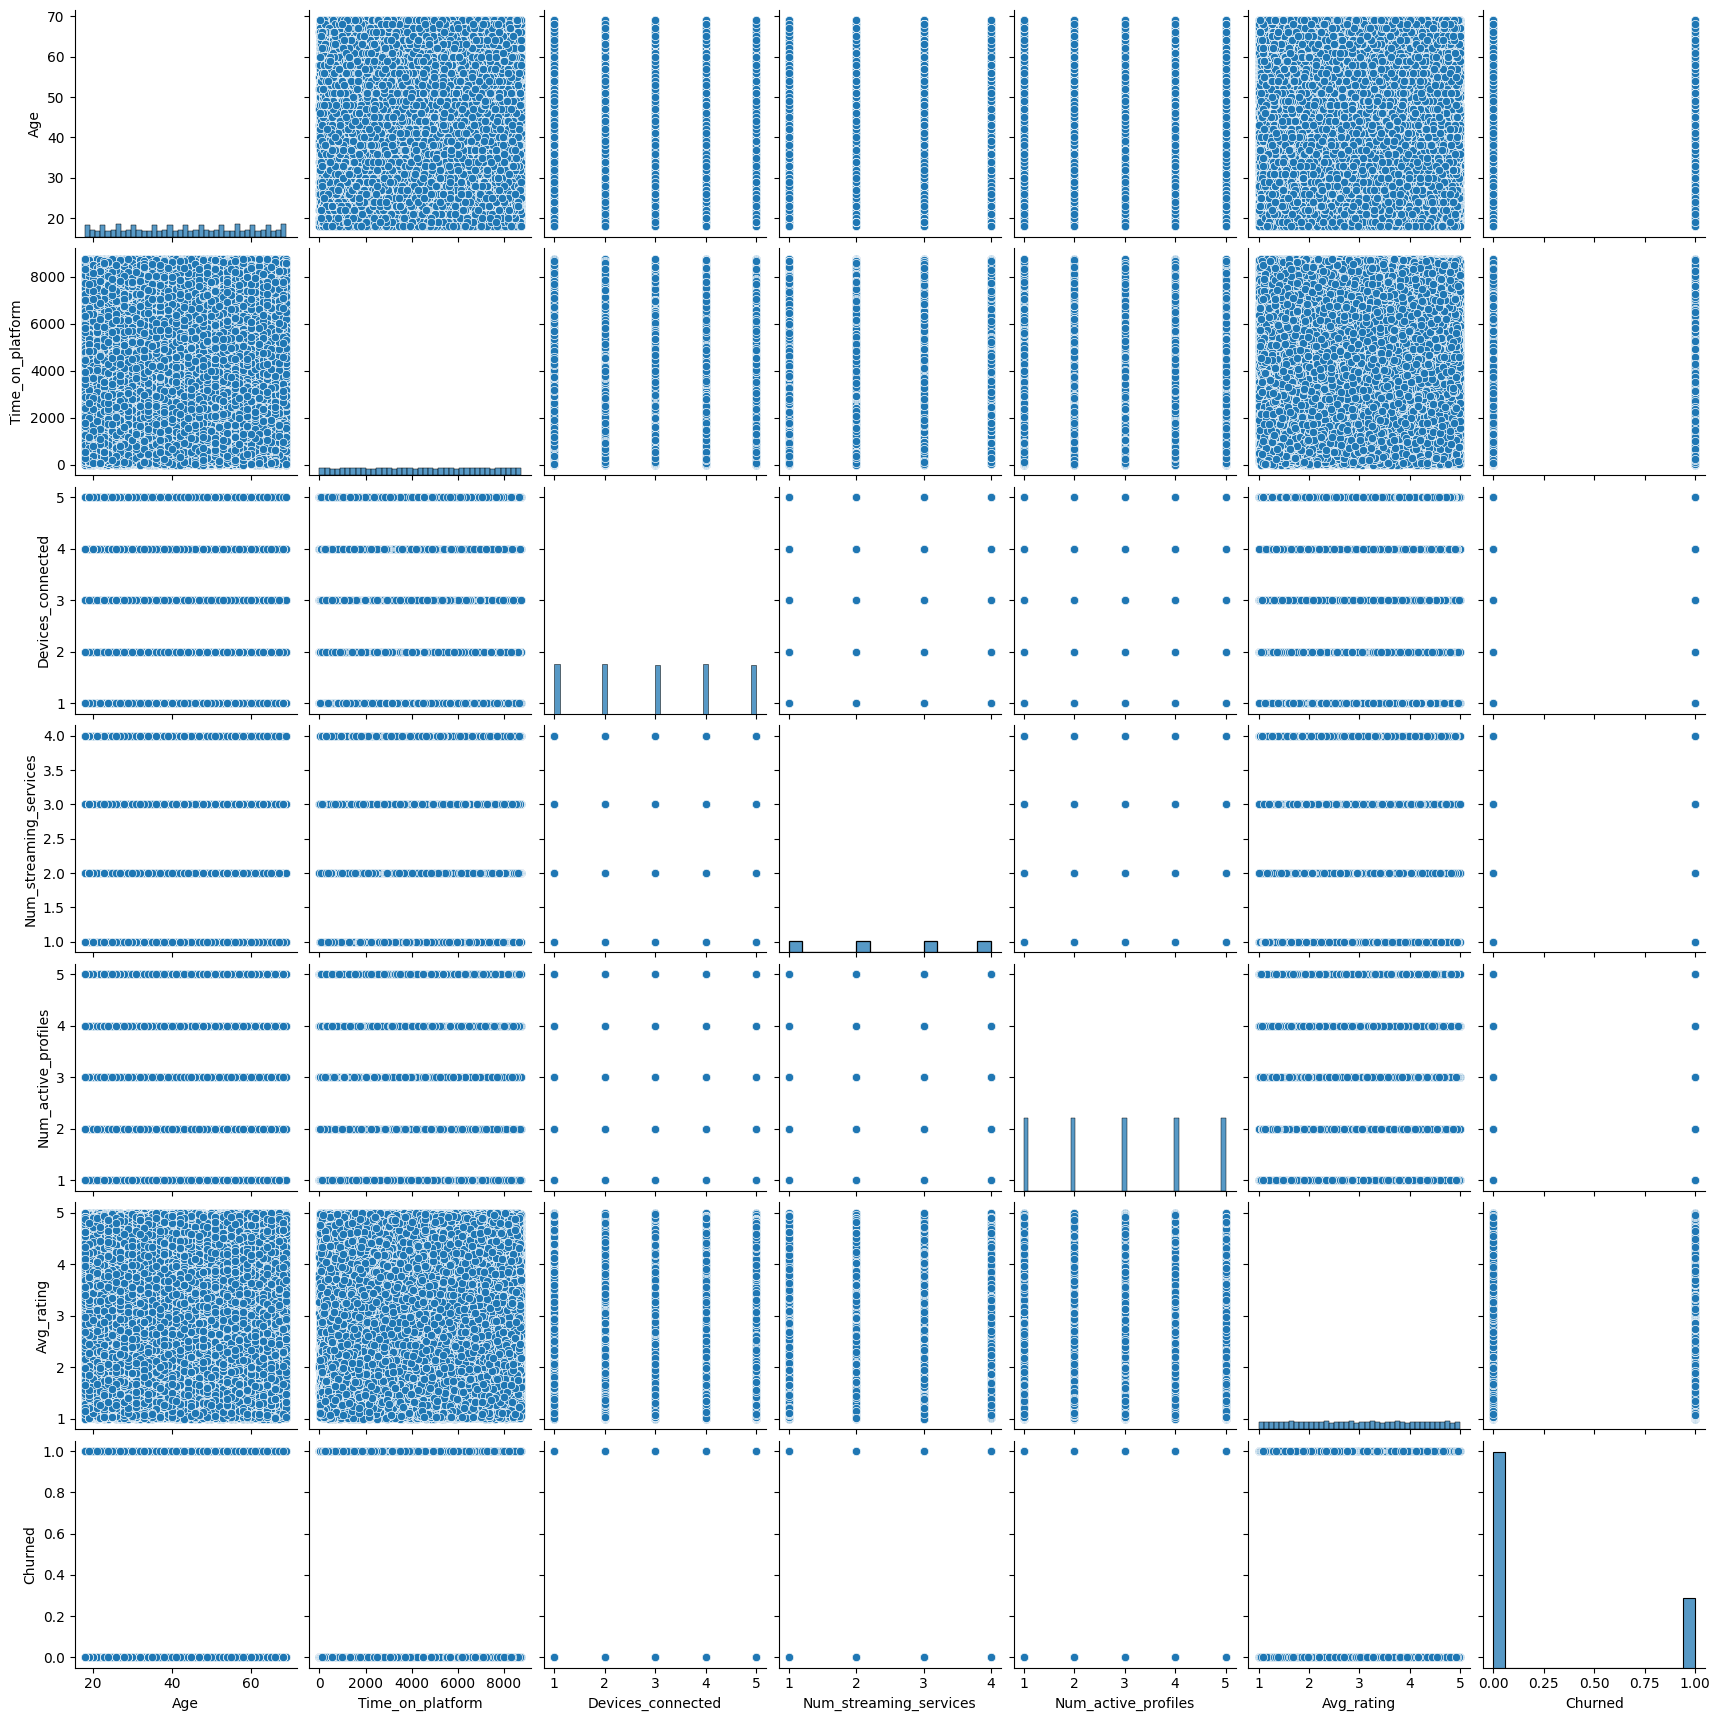

In [ ]:
# Verificação da distribuição entre os parametros
sns.pairplot(base_dados)

## Tratamento dos dados

In [ ]:
# Aplivando valor 0 a determinados valores nulos de colunas especificas
base_dados[['Time_on_platform','Num_streaming_services','Churned','Avg_rating','Devices_connected']] = base_dados[['Time_on_platform','Num_streaming_services','Churned','Avg_rating','Devices_connected']].fillna(0)


In [ ]:
# Remoção de linhas nula de determinadas colunas
base_dados = base_dados.dropna(subset=['Gender','Subscription_type','Age'])

In [ ]:
# Verificação de quantos valores nulos sobraram
base_dados.isnull().sum()

Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64

In [ ]:
# Substituindo os valores 0 e 1 por "No" e "Yes", respectivamente
base_dados['Churned'] = base_dados['Churned'].replace({0: 'No', 1: 'Yes'})

<ipython-input-10-90eb3c652aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_dados['Churned'] = base_dados['Churned'].replace({0: 'No', 1: 'Yes'})


In [ ]:
# Obtendo uma lista das colunas que têm o tipo float
colunas_float = base_dados.select_dtypes(include=['float']).columns.tolist()
# Transformando colunas no formato float para int
base_dados[colunas_float] = base_dados[colunas_float].astype('int64')

<ipython-input-11-cc0ce591bc71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_dados[colunas_float] = base_dados[colunas_float].astype('int64')


## Definindo Variaveis Explicativas e Descritivas

In [ ]:
base_dados_definido = base_dados.copy()
# a. Definir variáveis X e y para o modelo
X = base_dados_definido.drop(columns=['Churned', 'User_id'])  # Features
Y = base_dados_definido['Churned']  # Variável alvo

In [ ]:
# criar variáveis dummy
X = pd.get_dummies(X, columns=['Gender', 'Subscription_type'])


In [ ]:
# Convertendo variáveis categóricas para numéricas, se necessário
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
# Separar em treino e teste
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)


In [ ]:
# Normalizar os dados
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

## Modelagem dos Dados - Regressão Logística

In [ ]:
# b. Realizar o .fit do modelo
LR = LogisticRegression()
LR.fit(X_train_scaled, Y_train)


LogisticRegression()

In [ ]:
# c. Realizar a modelagem
Y_pred_LR = LR.predict(X_test_scaled)
Y_predict = LR.predict(X_scaled)


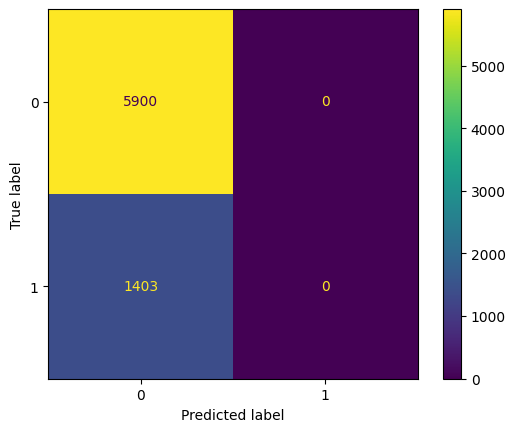

In [ ]:
# e. Plotar matriz de confusão
cm = metrics.confusion_matrix(Y_test, Y_pred_LR, labels=LR.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [ ]:
# f. Printar métricas
print(metrics.classification_report(Y_test, Y_pred_LR))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      5900
           1       0.00      0.00      0.00      1403

    accuracy                           0.81      7303
   macro avg       0.40      0.50      0.45      7303
weighted avg       0.65      0.81      0.72      7303



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

r = r2_score(Y_test, Y_pred_LR)
r_sq = LR.score(X, Y)
MSE_LR = metrics.mean_absolute_error(Y_test, Y_pred_LR)
print('Coeficiente de Determinação (R²):', r_sq)
print('Base por base:', r)
print('MAE: '+str(MSE_LR))

Coeficiente de Determinação (R²): 0.8067643434205121
Base por base: -0.23779661016949127
MAE: 0.19211283034369436


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
# Juntar os DataFrames
df_LR_results = base_dados.copy()
df_LR_results['Churned_pred'] = Y_predict
df_LR_results.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id,Churned_pred
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4,0
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31,0
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d,0
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2,0
5,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9,0


In [ ]:
# Criar um DataFrame vazio com colunas 'modelo', 'r2' e 'MSE'
df_final = pd.DataFrame(columns=['modelo', 'r2', 'MSE','df_dados'])
df_final.loc[0] = ['LR', round((r_sq*100), 2), MSE_LR, 'df_LR_results']
df_final

,modelo,r2,MSE,df_dados
0,LR,80.68,0.192113,df_LR_results


## Modelagem dos Dados - Random Forest

In [ ]:
# Criar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [ ]:
# Treinar o modelo
rf_model.fit(X_train_scaled, Y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Fazer previsões
Y_pred_rf = rf_model.predict(X_test_scaled)
Y_predict = rf_model.predict(X_scaled)

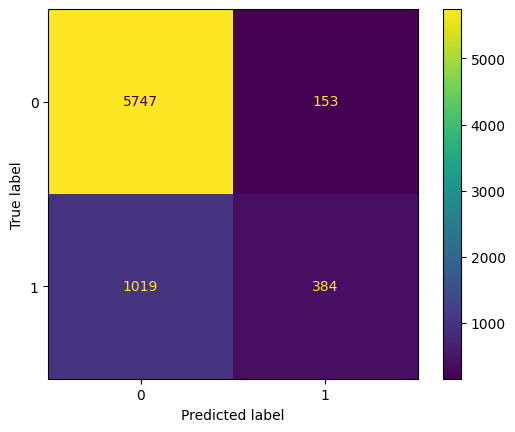

In [ ]:
# Plotar matriz de confusão
cm_rf = metrics.confusion_matrix(Y_test, Y_pred_rf)
disp_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot()
plt.show()

In [ ]:
# Printar métricas
print("Relatório de classificação:")
print(metrics.classification_report(Y_test, Y_pred_rf))

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      5900
           1       0.72      0.27      0.40      1403

    accuracy                           0.84      7303
   macro avg       0.78      0.62      0.65      7303
weighted avg       0.82      0.84      0.81      7303



In [ ]:
r = r2_score(Y_test, Y_pred_rf)
r_sq = rf_model.score(X, Y)
MSE_rf = metrics.mean_absolute_error(Y_test, Y_pred_rf)
print('Coeficiente de Determinação (R²):', r_sq)
print('Base por base:', r)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Coeficiente de Determinação (R²): 0.7935642886485006
Base por base: -0.03399688319219085


In [ ]:
# Juntar os DataFrames
df_rf_results = base_dados.copy()
df_rf_results['Churned_pred'] = Y_predict
df_rf_results.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id,Churned_pred
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4,0
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31,0
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d,1
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2,0
5,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9,0


In [ ]:
# Adicionar mais uma linha sem alterar os dados existentes
nova_linha = pd.DataFrame({'modelo': ['rf_model'], 'r2': [round((r_sq*100), 2)], 'MSE': [MSE_rf], 'df_dados': ['df_rf_results']})
# Concatenar o DataFrame original com a nova linha
df_final = pd.concat([df_final, nova_linha], ignore_index=True)

## Modelagem de Dados - Tunning

O termo "tuning" é frequentemente usado para descrever o ajuste de hiperparâmetros para otimizar o desempenho do modelo.

In [ ]:
default_radon_forest_params = {'bootstrap': [False],
 'criterion': ['gini', "entropy"],
 'max_depth': [15],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [150],
 'random_state': [42]}

grid_search = GridSearchCV(rf_model, default_radon_forest_params, scoring='r2',cv=2, n_jobs=1)

In [ ]:
grid_search.fit(X_train_scaled,Y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=1,
             param_grid={'bootstrap': [False], 'criterion': ['gini', 'entropy'],
                         'max_depth': [15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [150], 'random_state': [42]},
             scoring='r2')

In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

RandomForestClassifier(bootstrap=False, max_depth=15, n_estimators=150,
                       random_state=42)
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42}


In [ ]:
best_model = grid_search.best_estimator_
parameters = best_model.get_params()

In [ ]:
rf_tunned = RandomForestClassifier(**parameters)
rf_tunned.fit(X_train_scaled,Y_train)
rf_tunned_pred = rf_tunned.predict(X_test_scaled)
Y_predict = rf_tunned.predict(X_scaled)

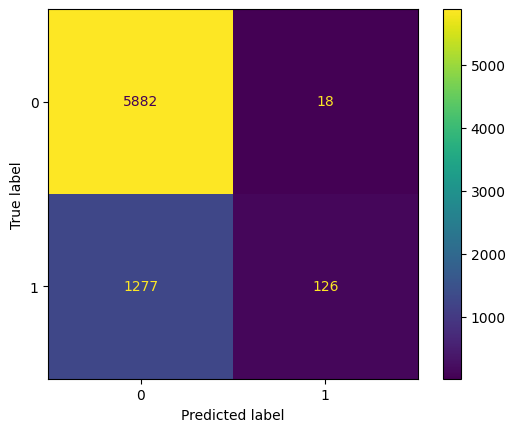

In [ ]:
# Plotar matriz de confusão
cm_rf = metrics.confusion_matrix(Y_test, rf_tunned_pred)
disp_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot()
plt.show()

In [ ]:
r_sq = rf_tunned.score(X_test_scaled,Y_test)
r = r2_score(Y_test,rf_tunned_pred)
MSE_tunned = metrics.mean_absolute_error(Y_test, rf_tunned_pred)
print('Coeficiente de Determinação (R²):', r_sq)
print('Base por base:', r)
print('MAE: '+str(MSE_tunned))

Coeficiente de Determinação (R²): 0.8226756127618787
Base por base: -0.14251362093335085
MAE: 0.17732438723812133


In [ ]:
# Juntar os DataFrames
df_rftunned_results = base_dados.copy()
df_rftunned_results['Churned_pred'] = Y_predict
df_rftunned_results.head()


,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id,Churned_pred
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4,0
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31,0
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d,1
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2,0
5,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9,0


In [ ]:
# Adicionar mais uma linha sem alterar os dados existentes
nova_linha = pd.DataFrame({'modelo': ['rf_tunned'], 'r2': [round((r_sq*100), 2)], 'MSE': [MSE_tunned], 'df_dados': ['df_rftunned_results']})
# Concatenar o DataFrame original com a nova linha
df_final = pd.concat([df_final, nova_linha], ignore_index=True)

## Produto Final

In [ ]:
df_final

,modelo,r2,MSE,df_dados
0,LR,80.68,0.192113,df_LR_results
1,rf_model,79.36,0.160482,df_rf_results
2,rf_tunned,82.27,0.177324,df_rftunned_results


Dentre as opções do DataFrame Final, que é composto por:

- Modelo: Definição de qual modelo de regressão foi aplicado
- r2: Metrica de Coeficiente de Determinação, indicando a performance da previsão
- MSE: Contem a média do erro absoluto
- df_dados: é o dataset com a base inicial e com a previsão de quais são os futuros possiveis churned determinado por cada modelo.

In [ ]:
conjunto_previsao = {
    'df_LR_results': df_LR_results,
    'df_rf_results': df_rf_results,
    'df_rftunned_results': df_rftunned_results
}

conjunto_modelos = {
    'LR': 'Regressão Logística',
    'rf_model': 'Random Forest Classifier',
    'rf_tunned': 'Random Forest Classifier com definição de Hiperparametros'
}

In [ ]:
indice_maior_r2 = df_final['r2'].idxmax()
linha_maior_r2 = df_final.loc[indice_maior_r2]
linha_maior_r2

modelo                rf_tunned
r2                        82.27
MSE                    0.177324
df_dados    df_rftunned_results
Name: 2, dtype: object

In [ ]:
# Extrair informações da linha com o maior valor de r2
modelo_maior_r2 = linha_maior_r2['modelo']
r2_maior = linha_maior_r2['r2']
mse_maior = linha_maior_r2['MSE']
df_dados_maior_r2 = linha_maior_r2['df_dados']

# Gerar texto informativo
texto_informativo = f"Dentre as possibilidades, o melhor modelo é {conjunto_modelos[modelo_maior_r2]}, apresentando um r² de {r2_maior}% com erro médio absoluto de {round(mse_maior,2)}."

# Salvar o DataFrame como um arquivo CSV
df_previsao = conjunto_previsao[df_dados_maior_r2]
nome_arquivo_csv = 'Previsao_Churned.csv'
df_previsao.to_csv(nome_arquivo_csv, index=False)

# Exibir texto informativo
print(texto_informativo)
print(f"DataFrame salvo como '{nome_arquivo_csv}'.")

Dentre as possibilidades, o melhor modelo é Random Forest Classifier com definição de Hiperparametros, apresentando um r² de 82.27% com erro médio absoluto de 0.18.
DataFrame salvo como 'Previsao_Churned.csv'.


Analise exploratoria, comparando a base atual e o perfil dos possiveis Chuerned previstos.

In [ ]:
df = df_previsao.copy()
df_churned_prev = df_previsao.query('Churned != "Yes" and Churned_pred == 1').copy()

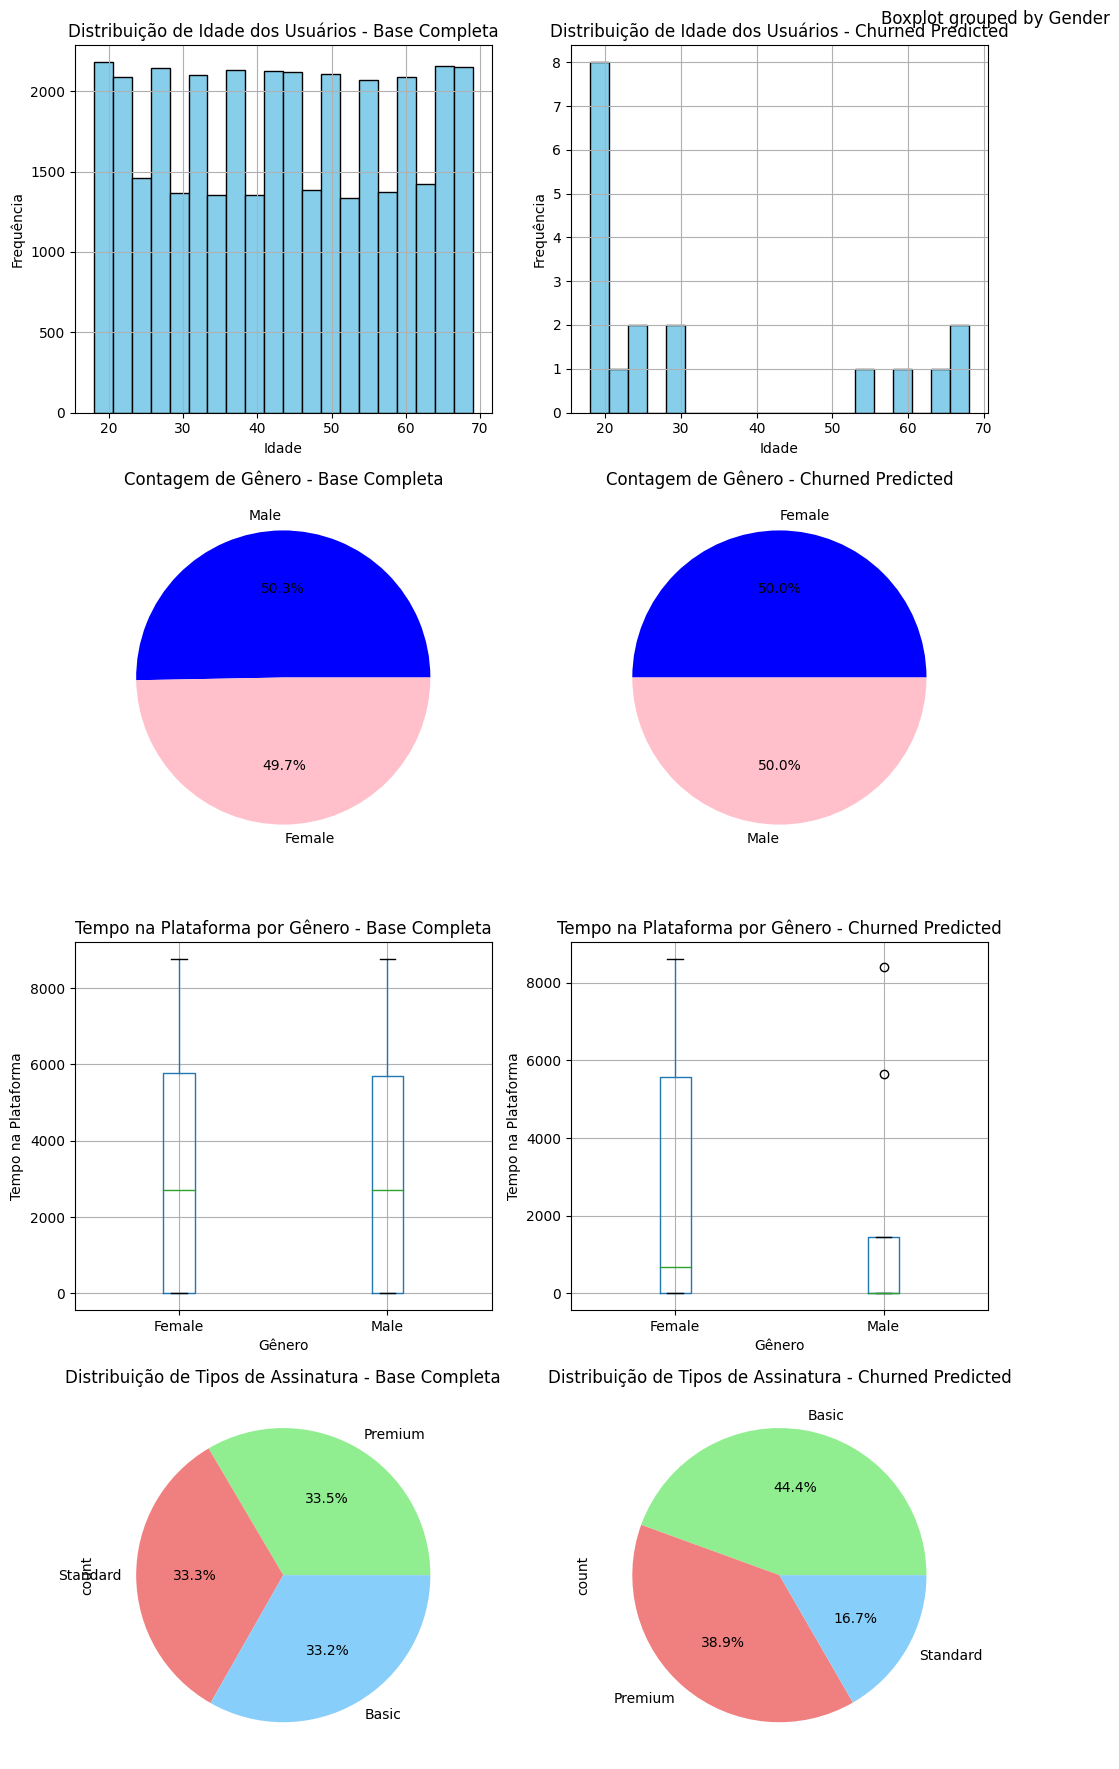

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(20, 18))
# Histograma da idade dos usuários (Base completa)
axs[0, 0].hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribuição de Idade dos Usuários - Base Completa')
axs[0, 0].set_xlabel('Idade')
axs[0, 0].set_ylabel('Frequência')
axs[0, 0].grid(True)

# Histograma da idade dos usuários (Churned predicted)
axs[0, 1].hist(df_churned_prev['Age'], bins=20, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribuição de Idade dos Usuários - Churned Predicted')
axs[0, 1].set_xlabel('Idade')
axs[0, 1].set_ylabel('Frequência')
axs[0, 1].grid(True)

# Gráfico de rosca da contagem de gênero (Base completa)
df['Gender'].value_counts().plot(kind='pie', ax=axs[1, 0], autopct='%1.1f%%', colors=['blue', 'pink'])
axs[1, 0].set_title('Contagem de Gênero - Base Completa')
axs[1, 0].set_ylabel('')
axs[1, 0].grid(True)

# Gráfico de rosca da contagem de gênero (Churned predicted)
df_churned_prev['Gender'].value_counts().plot(kind='pie', ax=axs[1, 1], autopct='%1.1f%%', colors=['blue', 'pink'])
axs[1, 1].set_title('Contagem de Gênero - Churned Predicted')
axs[1, 1].set_ylabel('')
axs[1, 1].grid(True)

# Boxplot do tempo na plataforma por gênero (Base completa)
df.boxplot(column='Time_on_platform', by='Gender', ax=axs[2, 0])
axs[2, 0].set_title('Tempo na Plataforma por Gênero - Base Completa')
axs[2, 0].set_xlabel('Gênero')
axs[2, 0].set_ylabel('Tempo na Plataforma')
axs[2, 0].grid(True)

# Boxplot do tempo na plataforma por gênero (Churned predicted)
df_churned_prev.boxplot(column='Time_on_platform', by='Gender', ax=axs[2, 1])
axs[2, 1].set_title('Tempo na Plataforma por Gênero - Churned Predicted')
axs[2, 1].set_xlabel('Gênero')
axs[2, 1].set_ylabel('Tempo na Plataforma')
axs[2, 1].grid(True)

# Gráfico de pizza da distribuição de tipos de assinatura
df['Subscription_type'].value_counts().plot(kind='pie', ax=axs[3, 0], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightskyblue'])
axs[3, 0].set_title('Distribuição de Tipos de Assinatura - Base Completa')
axs[3, 0].set_xlabel('')
axs[3, 0].grid(True)

# Gráfico de pizza da distribuição de tipos de assinatura
df_churned_prev['Subscription_type'].value_counts().plot(kind='pie', ax=axs[3, 1], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightskyblue'])
axs[3, 1].set_title('Distribuição de Tipos de Assinatura - Churned Predicted')
axs[3, 1].set_xlabel('')
axs[3, 1].grid(True)

# Remova os subplots excedentes
for i in range(4):
    for j in range(2, 4):
        axs[i, j].remove()

plt.tight_layout()
plt.show()